# Functions for evaluating signal-to-noise ratio (SNR)

Isaac Cheng - January 2022

Tries to reproduce Table 3-6 of the CASTOR Science Maturation Study.

Resources:
- [CCD Signal/Noise](http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/instruments/L14/index.html)


In [1]:
# I only need the following line since I'm using remote VS Code
%cd "/arc/home/IsaacCheng/CASTOR/ETC/notebooks"

import numpy as np
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.core.display import display

# Import my own modules
import sys

sys.path.append("../")
import src.constants as const
from src.conversions import mag_to_flux, fnu_to_flam, fnu_to_photlam, flam_to_photlam
from src.energy import calc_photon_energy
from src.load_files import load_sky_background, load_passbands

/arc/home/IsaacCheng/CASTOR/ETC/notebooks


## Trying to find the time required to reach a given SNR...


In [2]:
#
# Set parameters
#
RESOLUTION = 1 * u.nm  # common resolution for interpolation
PASSBAND_TOT_LIMITS = [
    min(const.PASSBAND_LIMITS.values(), key=lambda x: x[0])[0] * u.um,
    max(const.PASSBAND_LIMITS.values(), key=lambda x: x[1])[1] * u.um,
]  # minimum and maximum wavelength covered by the telescope
PASSBANDS = const.PASSBANDS
# NPIX = 1.4  # number of pixels of the source
# NPIX = (
#     np.pi * (1.4 * const.FWHM / 2) ** 2 / (const.PX_SCALE) ** 2
# )  # number of pixels of the source
NPIX = (
    np.pi * (1.4 * const.FWHM / 2) ** 2 / (1378.8 / 2 / 5760) ** 2
)  # number of pixels of the source
INTERP_KIND = "quadratic"  # type of interpolation to use for sky background
print(NPIX)


2.417858491227517


Load passband data and noise


In [3]:
#
# Passband response curves
#
castor_passbands = load_passbands(filters=PASSBANDS, limits=None, resolution=RESOLUTION)
#
# Earthshine and zodiacal light
#
sky_background = load_sky_background(
    resolution=RESOLUTION, limits=PASSBAND_TOT_LIMITS, kind=INTERP_KIND
)  # background initially in units of erg/cm^2/s/A/arcsec^2
for col in sky_background.columns:
    if col == "wavelength":
        continue
    # (Method 1)
    # sky_flam = sky_background[col] * const.PX_AREA  # erg/cm^2/s/A
    # sky_photlam = flam_to_photlam(sky_flam, sky_background["wavelength"] * u.AA)  # photons/s/cm^2/A
    # sky_background[col] = sky_photlam * const.APER_AREA  # photons/s/A
    # (Method 2)
    sky_background[col] = (
        sky_background[col]
        * const.PX_AREA
        * const.APER_AREA
        / calc_photon_energy(
            wavelength=sky_background["wavelength"] * u.AA, wavelength_err=0.0
        )[0]
    )  # photon/s/A
#
# Geocoronal emission (assume geocoronal emission constant over entire aperture)
#
# (Method 1)
# Convert to flam
geo_background = const.GEOCORONAL_FLUX * const.PX_AREA  # erg/cm^2/s/A
# Convert to photlam
geo_background = flam_to_photlam(
    geo_background, const.GEOCORONAL_WAVELENGTH * u.AA
)  # photons/s/cm^2/A
# Convert to photon/s
geo_background *= const.APER_AREA  # photon/s/A
# (Method 2)
geo_background2 = (
    const.GEOCORONAL_FLUX
    * const.PX_AREA
    * const.APER_AREA
    / calc_photon_energy(
        wavelength=const.GEOCORONAL_WAVELENGTH * u.AA, wavelength_err=0.0
    )[0]
)  # photon/s/A
#
# Dark current
#
dark_current = const.DARK_CURRENT * NPIX  # electron/s
#
# Read noise
#
read_noise_sq = const.READ_NOISE ** 2 * NPIX  # electrons^2


In [4]:
# castor_passbands["uv"][abs(castor_passbands["uv"]["wavelength"]-0.25)<1e-6]
for band, df in castor_passbands.items():
    print(band)
    display(df)

uv


,wavelength,throughput
0,0.150,0.014345
1,0.151,0.015924
2,0.152,0.017648
3,0.153,0.019521
4,0.154,0.021553
...,...,...
146,0.296,0.017400
147,0.297,0.013037
148,0.298,0.009245
149,0.299,0.006053


u


,wavelength,throughput
0,0.300,0.524463
1,0.301,0.527992
2,0.302,0.531407
3,0.303,0.534705
4,0.304,0.537884
...,...,...
96,0.396,0.328489
97,0.397,0.313956
98,0.398,0.299435
99,0.399,0.284926


g


,wavelength,throughput
0,0.400,0.343162
1,0.401,0.360624
2,0.402,0.376599
3,0.403,0.391541
4,0.404,0.405954
...,...,...
146,0.546,0.554785
147,0.547,0.540715
148,0.548,0.526205
149,0.549,0.511509


In [5]:
sky_background

,wavelength,earthshine,zodiacal_light,total_sky_background
0,1500.0,NaN,NaN,NaN
1,1510.0,NaN,NaN,NaN
2,1520.0,NaN,NaN,NaN
3,1530.0,NaN,NaN,NaN
4,1540.0,NaN,NaN,NaN
...,...,...,...,...
396,5460.0,0.000055,0.000111,0.000167
397,5470.0,0.000055,0.000112,0.000167
398,5480.0,0.000055,0.000112,0.000167
399,5490.0,0.000055,0.000112,0.000168


In [6]:
sky_background_raw = load_sky_background(limits=PASSBAND_TOT_LIMITS)
for col in sky_background_raw.columns:
    if col == "wavelength":
        continue
    sky_background_raw[col] = (
        sky_background_raw[col]
        * const.PX_AREA
        * const.APER_AREA
        / calc_photon_energy(
            wavelength=sky_background_raw["wavelength"] * u.AA, wavelength_err=0.0
        )[0]
    )  # photon/s/A
sky_background_raw

,wavelength,earthshine,zodiacal_light,total_sky_background
0,2000,6.080923e-09,6.278612e-07,6.341873e-07
1,2500,1.512323e-08,3.785750e-06,3.795634e-06
2,3000,1.696174e-06,1.933401e-05,2.099460e-05
3,3500,1.152726e-05,3.764004e-05,4.912579e-05
4,4000,2.625314e-05,4.934325e-05,7.559639e-05
5,4500,4.608137e-05,8.842642e-05,1.346857e-04
6,5000,5.199228e-05,1.002285e-04,1.522208e-04


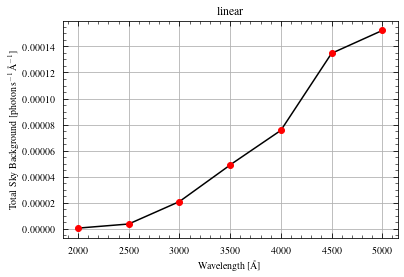

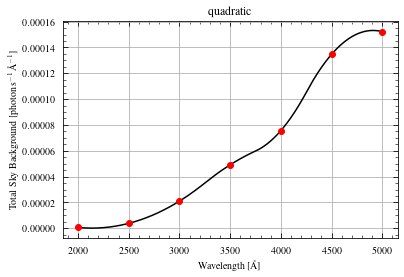

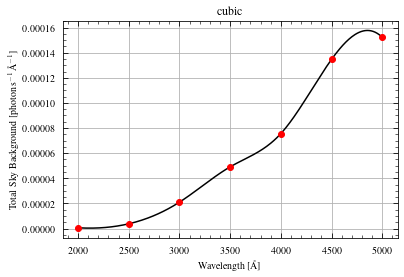

In [9]:
interp_kinds = ["linear", "quadratic", "cubic"]
tmp_wavelengths = np.arange(PASSBAND_TOT_LIMITS[0], PASSBAND_TOT_LIMITS[1] + 0.5 * RESOLUTION.to(u.AA).value, RESOLUTION.to(u.AA).value)
for kind in interp_kinds:
    tmp_interp = interp1d(
        sky_background_raw["wavelength"].values,
        sky_background_raw["total_sky_background"].values,
        kind=kind,
        bounds_error=False,
        fill_value=np.nan,
    )
    fig, ax = plt.subplots()
    ax.plot(tmp_wavelengths, tmp_interp(tmp_wavelengths), "k-")
    ax.plot(
        sky_background_raw["wavelength"], sky_background_raw["total_sky_background"], "ro"
    )
    ax.set_xlabel(r"Wavelength [\AA]")
    ax.set_ylabel(r"Total Sky Background [$\rm photon\,s^{-1}\,$\AA$^{-1}$]")
    ax.set_title(kind)
    plt.show()


In [6]:
#
# Set AB magnitudes of the point sources
#
ab_mags = np.arange(22.0, 29.0, 0.5)  # relative AB magnitudes
#
# Convert to flam (erg/s/cm^2/A) and photlam (photons/s/cm^2/A)
#
ab_fnu = mag_to_flux(ab_mags, mag_err=0.0, zpt=-48.60)[0]  # erg/s/cm^2/Hz
ab_flam = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # erg/s/cm^2/A
ab_photlam = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # photon/s/cm^2/A
ab_phot_rate_per_aa = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # photons/s/A
for band in PASSBANDS:
    wavelengths = castor_passbands[band]["wavelength"].values * u.um
    for i, ab_mag in enumerate(ab_mags):
        ab_flam[band][ab_mag] = fnu_to_flam(ab_fnu[i], wavelengths)
        photlam = fnu_to_photlam(ab_fnu[i], wavelengths)
        ab_photlam[band][ab_mag] = photlam
        ab_phot_rate_per_aa[band][ab_mag] = photlam * const.APER_AREA


In [7]:
# mywave = abs(castor_passbands["uv"]["wavelength"].values - 0.25) < 1e-6
# ab_phot_rate_per_aa["uv"][22][mywave]

In [7]:
#
# Integrate flux over passband---i.e., get all relevant quantites in units of electrons/s
#
ab_source_e_rate = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # electron/s
ab_sky_e_rate = dict.fromkeys(PASSBANDS)  # electron/s
for band in PASSBANDS:
    throughput = castor_passbands[band]["throughput"].values
    #
    # Calculate total background noise from sky and geocoronal emission. Assume background
    # is constant over wavelength resolution (e.g., 10 angstroms) and is uniform over the
    # whole aperture.
    #
    band_start = (
        (castor_passbands[band]["wavelength"].iloc[0] * u.um).to(u.AA).value
    )
    band_end = (castor_passbands[band]["wavelength"].iloc[-1] * u.um).to(u.AA).value
    is_in_band = (sky_background["wavelength"] >= band_start) & (
        sky_background["wavelength"] <= band_end
    )
    background = np.nansum(
        sky_background["total_sky_background"][is_in_band]
        * RESOLUTION.to(u.AA).value
        * throughput
    ) * NPIX
    # Add geocoronal emission line [O II] 2471A to the relevant passband
    if (const.GEOCORONAL_WAVELENGTH >= band_start) & (
        const.GEOCORONAL_WAVELENGTH <= band_end
    ):
        throughput_interp = interp1d(
            castor_passbands[band]["wavelength"].values,
            throughput,
            kind=INTERP_KIND,
            bounds_error=False,
            fill_value=np.nan,
        )
        geo_throughput = throughput_interp(
            (const.GEOCORONAL_WAVELENGTH * u.AA).to(u.um)
        )
        background += geo_background * geo_throughput * NPIX * const.GEOCORONAL_LINEWIDTH
    ab_sky_e_rate[band] = background
    #
    # Calculate total signal in band
    #
    for i, ab_mag in enumerate(ab_mags):
        # Assume flux is constant over wavelength resolution (e.g., 10 angstroms)
        e_rate = np.nansum(
            ab_phot_rate_per_aa[band][ab_mag]
            * throughput
            * RESOLUTION.to(u.AA).value
        )
        ab_source_e_rate[band][ab_mag] = e_rate

In [8]:
ab_source_e_rate

,uv,u,g
22.0,9.66619,10.1858,12.8361
22.5,6.09895,6.42678,8.09904
23.0,3.84818,4.05502,5.11015
23.5,2.42804,2.55855,3.22428
24.0,1.53199,1.61433,2.03439
24.5,0.966619,1.01858,1.28361
25.0,0.609895,0.642678,0.809904
25.5,0.384818,0.405502,0.511015
26.0,0.242804,0.255855,0.322428
26.5,0.153199,0.161433,0.203439


In [9]:
ab_sky_e_rate

{'uv': 0.0024258139214221176,
 'u': 0.05766924784060057,
 'g': 0.2972939592158324}

In [11]:
# #
# # Integrate flux over passband---i.e., get all relevant quantites in units of electrons/s
# #
# ab_source_e_rate = pd.DataFrame(index=ab_mags, columns=PASSBANDS)  # electron/s
# ab_sky_e_rate = dict.fromkeys(PASSBANDS)  # electron/s
# for band in PASSBANDS:
#     throughput = castor_passbands[band]["throughput"].values
#     #
#     # Calculate total background noise from sky and geocoronal emission. Assume background
#     # is constant over wavelength resolution (e.g., 10 angstroms) and is uniform over the
#     # whole aperture.
#     #
#     band_start = (
#         (castor_passbands[band]["wavelength"].iloc[0] * u.um).to(u.AA).value
#     )
#     band_end = (castor_passbands[band]["wavelength"].iloc[-1] * u.um).to(u.AA).value
#     is_in_band = (sky_background["wavelength"] >= band_start) & (
#         sky_background["wavelength"] <= band_end
#     )
#     background = (
#         sky_background["total_sky_background"][is_in_band]
#         * RESOLUTION.to(u.AA).value
#         * throughput
#     ) * NPIX
#     ab_sky_e_rate[band] = background
#     #
#     # Calculate total signal in band
#     #
#     for i, ab_mag in enumerate(ab_mags):
#         # Assume flux is constant over wavelength resolution (e.g., 10 angstroms)
#         e_rate = (
#             ab_phot_rate_per_aa[band][ab_mag]
#             * throughput
#             * RESOLUTION.to(u.AA).value
#         )
#         ab_source_e_rate[band][ab_mag] = e_rate

In [12]:
# #
# TARGET_SNRS = [5, 10]
# #
# t_lim = {
#     snr: pd.DataFrame(index=ab_mags, columns=PASSBANDS) for snr in TARGET_SNRS
# } # time to reach magnitude given target SNR (s)
# for target_snr in TARGET_SNRS:
#     for band in PASSBANDS:
#         for ab_mag in ab_mags:
#             t = 10  # second
#             snr = 0  # signal to noise ratio
#             signal = ab_source_e_rate[band][ab_mag] * t  # electrons
#             noise = np.sqrt(
#                 signal
#                 + ab_sky_e_rate[band] * t
#                 + dark_current * t
#                 + read_noise_sq
#             )
#             snr = signal / noise
#             t_lim[target_snr][band][ab_mag] = snr

In [13]:
# mywave = abs(castor_passbands["uv"]["wavelength"].values - 0.25) < 1e-6
# # ab_phot_rate_per_aa["uv"][22][mywave]
# t_lim[5]["uv"][22][mywave]

In [10]:
#
TARGET_SNRS = [5, 10]
#
t_lim = {
    snr: pd.DataFrame(index=ab_mags, columns=PASSBANDS) for snr in TARGET_SNRS
} # time to reach magnitude given target SNR (s)
for target_snr in TARGET_SNRS:
    for band in PASSBANDS:
        for ab_mag in ab_mags:
            t = 0  # second
            snr = 0  # signal to noise ratio
            while snr < target_snr:
                t += 1
                signal = ab_source_e_rate[band][ab_mag] * t  # electrons
                noise = np.sqrt(
                    signal
                    + ab_sky_e_rate[band] * t
                    + dark_current * t
                    + read_noise_sq
                )
                snr = signal / noise
                if t >= 60000:
                    print(f"Exiting {band} band at AB magnitude of {ab_mag}")
                    break
            t_lim[target_snr][band][ab_mag] = t

In [11]:
for snr, df in t_lim.items():
    print("TARGET SNR:", snr)
    display(df)
    print(df.to_latex())

TARGET SNR: 5


,uv,u,g
22.0,4,4,4
22.5,7,6,5
23.0,10,10,8
23.5,16,16,13
24.0,26,25,21
24.5,41,40,34
25.0,65,64,57
25.5,103,104,100
26.0,167,174,182
26.5,272,299,352


\begin{tabular}{llll}
\toprule
{} &    uv &     u &     g \\
\midrule
22.0 &     4 &     4 &     4 \\
22.5 &     7 &     6 &     5 \\
23.0 &    10 &    10 &     8 \\
23.5 &    16 &    16 &    13 \\
24.0 &    26 &    25 &    21 \\
24.5 &    41 &    40 &    34 \\
25.0 &    65 &    64 &    57 \\
25.5 &   103 &   104 &   100 \\
26.0 &   167 &   174 &   182 \\
26.5 &   272 &   299 &   352 \\
27.0 &   451 &   535 &   726 \\
27.5 &   767 &  1007 &  1583 \\
28.0 &  1353 &  2015 &  3621 \\
28.5 &  2503 &  4285 &  8564 \\
\bottomrule
\end{tabular}

TARGET SNR: 10


,uv,u,g
22.0,13,12,10
22.5,20,19,15
23.0,31,30,25
23.5,49,47,40
24.0,78,76,65
24.5,124,123,109
25.0,199,201,189
25.5,321,334,342
26.0,523,571,650
26.5,867,1011,1306


\begin{tabular}{llll}
\toprule
{} &    uv &      u &      g \\
\midrule
22.0 &    13 &     12 &     10 \\
22.5 &    20 &     19 &     15 \\
23.0 &    31 &     30 &     25 \\
23.5 &    49 &     47 &     40 \\
24.0 &    78 &     76 &     65 \\
24.5 &   124 &    123 &    109 \\
25.0 &   199 &    201 &    189 \\
25.5 &   321 &    334 &    342 \\
26.0 &   523 &    571 &    650 \\
26.5 &   867 &   1011 &   1306 \\
27.0 &  1468 &   1876 &   2775 \\
27.5 &  2568 &   3672 &   6186 \\
28.0 &  4689 &   7607 &  14322 \\
28.5 &  9014 &  16599 &  34082 \\
\bottomrule
\end{tabular}



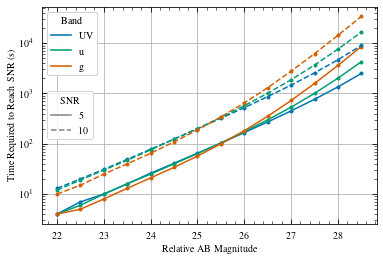

In [12]:
#
# Plot results
# 
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
# 
fig, ax = plt.subplots()
for snr in TARGET_SNRS:
    ls = plot_params[f"ls_{snr}"]
    for band in PASSBANDS:
        color = plot_params[f"c_{band}"]
        ax.plot(ab_mags, t_lim[snr][band], ls=ls, color=color, marker=".", label=band)
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in TARGET_SNRS]
leg1 = ax.legend(handles=handles1, labels=TARGET_SNRS, loc="center left", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in PASSBANDS]
leg2 = ax.legend(handles=handles2, labels=[band if band != "uv" else band.upper() for band in PASSBANDS], loc="upper left", title="Band")
ax.add_artist(leg2)
ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel("Time Required to Reach SNR (s)")
# ax.set_title("ETC SNR Calculation Results")
# fig.savefig(const.OUTPATH + f"etc_snr_times_npix{NPIX:.2f}.pdf")
plt.show()

In [13]:
# 
# Load Table 3-6
# 
tab36 = pd.read_csv(
    const.DATAPATH + "SMS_table_3-6.txt",
    sep=" ",
    header=0,
    comment="#",
)
tab36

,mag,uv_10,u_10,g_10,uv_5,u_5,g_5
0,22.0,31,20,19,9,6,6
1,22.5,49,32,30,14,9,8
2,23.0,78,51,48,22,14,14
3,23.5,123,81,78,34,22,22
4,24.0,197,129,128,56,36,36
5,24.5,309,208,217,87,59,59
6,25.0,498,339,372,141,95,100
7,25.5,783,569,655,219,155,171
8,26.0,1267,964,1206,356,266,323
9,26.5,2039,1698,2389,561,455,609


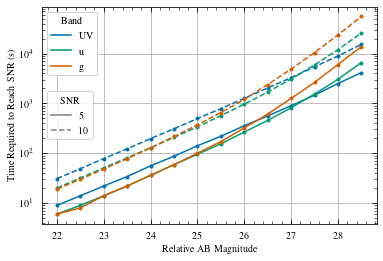

In [14]:
# 
# Plot Table 3-6 results
#
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
# 
fig, ax = plt.subplots()
for col in tab36.columns:
    if col == "mag":
        continue
    elif col[-2:] == "10":
        ls = plot_params["ls_10"]
    elif col[-1] == "5":
        ls = plot_params["ls_5"]
    else:
        raise ValueError("Unknown SNR")
    if col[:2] == "uv":
        color = plot_params["c_uv"]
    elif col[0] == "u":
        color = plot_params["c_u"]
    else:
        color = plot_params["c_g"]
    ax.plot(tab36["mag"], tab36[col], ls=ls, color=color, marker=".", label=col)
#
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in [5, 10]]
leg1 = ax.legend(handles=handles1, labels=[5, 10], loc="center left", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in ["uv", "u", "g"]]
leg2 = ax.legend(handles=handles2, labels=["UV", "u", "g"], loc="upper left", title="Band")
ax.add_artist(leg2)
ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel("Time Required to Reach SNR (s)")
# ax.set_title("Science Maturation Study Table 3-6 Results")
# fig.savefig(const.OUTPATH + f"tab3-6_snr_times_npix{NPIX:.2f}.pdf")
plt.show()

In [15]:
# 
# Calculate residuals
# 
residuals = pd.DataFrame({"mag": tab36["mag"]})
for snr in TARGET_SNRS:
    for band in PASSBANDS:
        residuals[f"{band}_{snr}"] = tab36[f"{band}_{snr}"].values - t_lim[snr][band].values
residuals

,mag,uv_5,u_5,g_5,uv_10,u_10,g_10
0,22.0,5,2,2,18,8,9
1,22.5,7,3,3,29,13,15
2,23.0,12,4,6,47,21,23
3,23.5,18,6,9,74,34,38
4,24.0,30,11,15,119,53,63
5,24.5,46,19,25,185,85,108
6,25.0,76,31,43,299,138,183
7,25.5,116,51,71,462,235,313
8,26.0,189,92,141,744,393,556
9,26.5,289,156,257,1172,687,1083


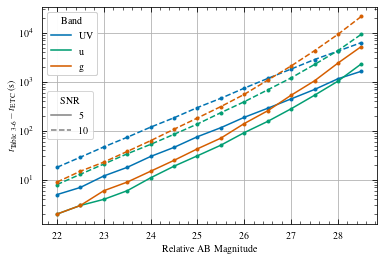

In [16]:
# 
# Plot residuals
# 
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
fig, ax = plt.subplots()
for col in residuals.columns:
    if col == "mag":
        continue
    elif col[-2:] == "10":
        ls = plot_params["ls_10"]
    elif col[-1] == "5":
        ls = plot_params["ls_5"]
    else:
        raise ValueError("Unknown SNR")
    if col[:2] == "uv":
        color = plot_params["c_uv"]
    elif col[0] == "u":
        color = plot_params["c_u"]
    else:
        color = plot_params["c_g"]
    ax.plot(residuals["mag"], residuals[col], ls=ls, color=color, marker=".", label=col)
#
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in [5, 10]]
leg1 = ax.legend(handles=handles1, labels=[5, 10], loc="center left", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in ["uv", "u", "g"]]
leg2 = ax.legend(handles=handles2, labels=["UV", "u", "g"], loc="upper left", title="Band")
ax.add_artist(leg2)
ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel(r"$t_{\scriptstyle\text{Table~3-6}} - t_{\rm\scriptstyle ETC}$ (s)")
# ax.set_title("Residuals")
# fig.savefig(const.OUTPATH + f"snr_times_residuals_npix{NPIX:.2f}.pdf")
plt.show()

In [17]:
#
# Calculate relative error
# 
rel_err = residuals.loc[:, residuals.columns != "mag"] / tab36.loc[:, residuals.columns != "mag"]
rel_err["mag"] = residuals["mag"]
rel_err

,g_10,g_5,u_10,u_5,uv_10,uv_5,mag
0,0.473684,0.333333,0.4,0.333333,0.580645,0.555556,22.0
1,0.5,0.375,0.40625,0.333333,0.591837,0.5,22.5
2,0.479167,0.428571,0.411765,0.285714,0.602564,0.545455,23.0
3,0.487179,0.409091,0.419753,0.272727,0.601626,0.529412,23.5
4,0.492188,0.416667,0.410853,0.305556,0.604061,0.535714,24.0
5,0.497696,0.423729,0.408654,0.322034,0.598706,0.528736,24.5
6,0.491935,0.43,0.40708,0.326316,0.600402,0.539007,25.0
7,0.477863,0.415205,0.413005,0.329032,0.590038,0.52968,25.5
8,0.461028,0.436533,0.407676,0.345865,0.587214,0.530899,26.0
9,0.453328,0.422003,0.404594,0.342857,0.574792,0.515152,26.5


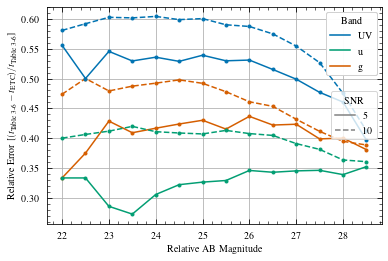

In [18]:
# 
# Plot relative error
# 
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "c_uv": sns.color_palette("colorblind")[0],
    "c_u": sns.color_palette("colorblind")[2],
    "c_g": sns.color_palette("colorblind")[3],
}
fig, ax = plt.subplots()
for col in rel_err.columns:
    if col == "mag":
        continue
    elif col[-2:] == "10":
        ls = plot_params["ls_10"]
    elif col[-1] == "5":
        ls = plot_params["ls_5"]
    else:
        raise ValueError("Unknown SNR")
    if col[:2] == "uv":
        color = plot_params["c_uv"]
    elif col[0] == "u":
        color = plot_params["c_u"]
    else:
        color = plot_params["c_g"]
    ax.plot(rel_err["mag"], rel_err[col], ls=ls, color=color, marker=".", label=col)
#
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in [5, 10]]
leg1 = ax.legend(handles=handles1, labels=[5, 10], loc="center right", title="SNR")
ax.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"c_{band}"])[0] for band in ["uv", "u", "g"]]
leg2 = ax.legend(handles=handles2, labels=["UV", "u", "g"], loc="upper right", title="Band")
ax.add_artist(leg2)
# ax.semilogy()
ax.set_xlabel("Relative AB Magnitude")
ax.set_ylabel(r"Relative Error [$(t_{\scriptstyle\text{Table~3-6}} - t_{\rm\scriptstyle ETC}) / t_{\scriptstyle\text{Table~3-6}}$]")
# ax.set_title("Relative Error")
# fig.savefig(const.OUTPATH + f"snr_times_rel_errs_npix{NPIX:.2f}.pdf")
plt.show()

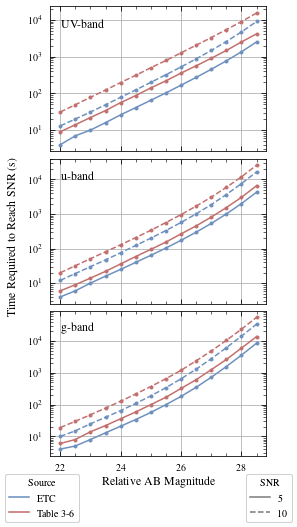

In [19]:
# 
# Plot just UV band
#
# BAND_TO_PLOT = "uv"
plot_params = {
    # Line styles for each SNR
    "ls_5": "-",
    "ls_10": "--",
    # Colours for each band
    "etc": sns.color_palette("vlag")[0],
    "tab36": sns.color_palette("vlag")[-1],
}
import matplotlib as mpl
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=mpl.figure.figaspect(2))
for band, ax in zip(PASSBANDS, axs):
    for snr in TARGET_SNRS:
        ls = plot_params[f"ls_{snr}"]
        ax.plot(ab_mags, t_lim[snr][band], ls=ls, color=plot_params["etc"], marker=".")
        ax.plot(tab36["mag"], tab36[f"{band}_{snr}"], ls=ls, color=plot_params["tab36"], marker=".")
    if band == "uv":
        band = band.upper()
    ax.text(0.05, 0.86, band + "-band", c="k", ha="left", transform=ax.transAxes, fontsize=12)
    ax.semilogy()
fig.subplots_adjust(top=0.9, left=0.15, right=0.9, bottom=0.12, hspace=0.05)
handles1 = [ax.plot([],[], color="grey", ls=plot_params[f"ls_{snr}"])[0] for snr in TARGET_SNRS]
leg1 = fig.legend(handles=handles1, labels=TARGET_SNRS, loc="lower right", title="SNR")
fig.add_artist(leg1)
handles2 = [ax.plot([],[], color=plot_params[f"{source}"])[0] for source in ["etc", "tab36"]]
leg2 = fig.legend(handles=handles2, labels=["ETC", "Table~3-6"], loc="lower left", title="Source")
fig.add_artist(leg2)
# fig.text(0.5, 0.05, "Relative AB Magnitude", ha="center", fontsize=12)
ax.set_xlabel("Relative AB Magnitude", fontsize=12)
fig.text(
    0.0,
    0.5,
    "Time Required to Reach SNR (s)",
    va="center",
    rotation="vertical",
    fontsize=12,
)
# fig.savefig(const.OUTPATH + f"all_snr_times_npix{NPIX:.2f}.pdf")
plt.show()

In [20]:
print(INTERP_KIND)

quadratic
